In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn import svm
from pandas import DataFrame

In [2]:
data = pd.read_csv('data_titanic_proyecto.csv')

In [3]:
data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [4]:
#feature enginering
sex = np.zeros(len(data))
sex[data['passenger_sex']== 'M'] = 1
sex[data['passenger_sex']== 'F'] = 0
data['passenger_sex'] = sex



In [5]:
clase = np.zeros(len(data))
clase[data['passenger_class']== 'Lower'] = 0
clase[data['passenger_class']== 'Upper'] = 1
data['passenger_class'] = clase
survived = np.zeros(len(data))
survived[data['passenger_survived']== 'N'] = 0
survived[data['passenger_survived']== 'Y'] = 1
data['passenger_survived'] = survived


In [6]:

data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)
Embarked = np.zeros(len(data))
Embarked[data['Embarked']== 'C'] = 1
Embarked[data['Embarked']== 'Q'] = 2
Embarked[data['Embarked']== 'S'] = 3
data['Embarked'] = Embarked


In [7]:
data['Age'].fillna(data['Age'].mean(),inplace=True)
#age = np.zeros(len(data))
#age[data['Age']<20] = 1
#age[(data['Age']>=20)&(train['Age']<60)] = 2
#age[(data['Age']>=60)] = 3
#data['Age'] = age
data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,3.0,0.0,1.0,0.0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1.0,1.0,0.0,1.0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,3.0,0.0,0.0,1.0
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.0,1.0,0.0,1.0
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,3.0,0.0,1.0,0.0


In [8]:
eliminar = ['PassengerId','Name', 'Ticket','Cabin']
data.drop(eliminar,axis=1, inplace=True)
data.head()

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,3.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,1.0,0.0,1.0
2,26.0,0,0,7.9250,3.0,0.0,0.0,1.0
3,35.0,1,0,53.1000,3.0,1.0,0.0,1.0
4,35.0,0,0,8.0500,3.0,0.0,1.0,0.0


In [9]:
#feature selection age 
x = data.iloc[:,0:7]  
y = data.iloc[:,-1] 

In [10]:
#separacion datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.30, random_state=42)


In [11]:
train = X_train.copy()
train["y"] = y_train
train
def pc():
    counts = train["y"].value_counts().to_dict()
    priors = {(k, v/len(y_train)) for k, v in counts.items()}
    return priors
pc()

{(0.0, 0.6193029490616622), (1.0, 0.3806970509383378)}

In [12]:
import math
def mediaVarianza():
    media_varianza = {}
    for c in train["y"].unique():
        filtro= train[(train['y'] == c)]
        mv = {}
        for xi in ["Age","SibSp","Parch","Fare","Embarked","passenger_class","passenger_sex"]:
            mv[xi] = []
            mv[xi].append(filtro[xi].mean())
            mv[xi].append(
                math.pow(filtro[xi].std(), 2))
        media_varianza[c] = mv
    return media_varianza
media_varianza = mediaVarianza()
def pdf(x, media, varianza):
    e = math.exp(-(math.pow(x - media, 2) / (2 * varianza)))
    return (1 / (math.sqrt(2 * math.pi * varianza))) * e


In [13]:

def predict():
    predictions = {}
    for _, row in X_test.iterrows():
        results = {}
        for k, v in pc():
            p = 0
            for xi in ["Age","SibSp","Parch","Fare","Embarked","passenger_class","passenger_sex"]:
                prob = pdf(row[xi], media_varianza[k][xi][0], media_varianza[k][xi][1])
                if prob > 0:
                    p += math.log(prob)
            results[k] = math.log(v) + p
        predictions[_] = max([key for key in results.keys() if results[key] == results[max(results, key=results.get)]])
    return predictions


In [14]:
def accurracy(predictions):
    correct = 0
    for i, t in X_test.iterrows():
        if y_test[i] == predictions[i]:
            correct += 1
    return (correct / len(X_test)) * 100.0
accurracy(predict())

79.27170868347339

In [94]:
#onehotcoding
a = np.unique(y_train, return_inverse=1)[1]
Y_train_logistic = (a.ravel()[:,None] == np.arange(a.max()+1)).astype(int)



In [74]:
m,n = X_train.shape

epochs=1000;
batch_=10;
tf.reset_default_graph()
with tf.name_scope('datos_entrenamiento'):
    x = tf.placeholder(tf.float32, [None, n], name = "X") 
    y = tf.placeholder(tf.float32, [None, 2], name = "Y") 
with tf.name_scope('parametros'):
    W = tf.Variable(tf.zeros([n,2]), name = "W") 
    b = tf.Variable(tf.zeros([2]), name = "B")
with tf.name_scope('modelo'):
    y_ = tf.matmul(x, W) + b
    prediction = tf.nn.sigmoid(y_)
with tf.name_scope('hyper-parameters'):
    learning_rate = tf.placeholder(tf.float32, [] ,name='learning_rate')
    reg = tf.placeholder(tf.float32, [] ,name='reg')
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( logits = y_, labels = y))
    l2 = tf.nn.l2_loss(W)
    loss = tf.reduce_mean(cross_entropy + reg * l2)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
    #tf.summary.scalar('cost',cross_entropy)
with tf.name_scope('accuracy'):
    correct_prediction = tf.to_float(tf.greater(prediction, 0.5))
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(y, correct_prediction)))
    #tf.summary.scalar('accuracy',accuracy)

#summaries = tf.summary.merge_all()

In [97]:
def trainLogistic(x_,y_,lr,freg):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_size = batch_
        batchs = int(np.around(len(X_train)/batch_size))
        batchs
        for i in range(epochs):
            i0 = 0
            i1 = batch_size-1
            for batch in range(batchs):
                x_batch = x_[i0:i1]
                y_batch = y_[i0:i1]
                optimizer,cost,accuracy_ = sess.run([train_step, cross_entropy,accuracy], feed_dict={x: x_batch,
                                               y: y_batch, learning_rate:lr,reg:freg})
                #if (i%100==0 and batch==10):
                    #print ('Epoch: ',i,'Batch:' ,batch, ' accuracy: ', accuracy_,' cost:',cost)
                i0 = i0+batch_size
                i1 = i1+batch_size
        save_path = saver.save(sess, "session.ckpt")

In [95]:
label_dict = {
        0: 'No Sobrevivió',
        1: 'Sobrevivió',
}
trainLogistic(X_train,Y_train_logistic,0.01,0.01)
def RegresionLogisticaTrie(X):
    with tf.Session() as sess:
        saver.restore(sess, "session.ckpt")
        predict = sess.run([prediction], feed_dict = {x: X, learning_rate:0.01,reg:0.01})
        categoria = np.argmax(predict)
        #print(predict,categoria)
        print(label_dict[categoria] ,' con probabilidad ' , str(round(np.max(predict) * 100,2)) , '%')
RegresionLogisticaTrie(X_validate[3:4])
y_validate[3:4]


INFO:tensorflow:Restoring parameters from session.ckpt
Sobrevivió  con probabilidad  99.94 %


618    1.0
Name: passenger_survived, dtype: float64

In [98]:
#accuracy error precicion recaall f1score
def RegresionLogistica(X,lr=0.01,freg=0.01):
    trainLogistic(X_train,Y_train_logistic,lr,freg)
    with tf.Session() as sess:
        saver.restore(sess, "session.ckpt")
        predict = sess.run([prediction], feed_dict = {x: X,learning_rate:lr,reg:freg})
        categoria = np.array(predict).argmax(-1)
        y_logistica = pd.Series(categoria.ravel())
        return y_logistica


In [78]:
def SupvectorMa(x,penalty=1):
    vectorMachine = svm.SVC(kernel='linear', C=penalty)  
    vectorMachine.fit(X_train, y_train) 
    y_svm = vectorMachine.predict(x)
    return y_svm


In [79]:
def arbolDecision(x,state = 100, depth = 2, leaf = 5):
    arbol = tree.DecisionTreeClassifier(criterion = "entropy", random_state = state, 
                max_depth = depth, min_samples_leaf = leaf)
    arbol.fit(X_train, y_train) 
    y_tree = arbol.predict(x)
    return y_tree


In [99]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



modelos = list()
accuracies = list()
f1s = list()
precisions = list()
recalls = list()
variables = list()

def saveModel(modelo, variable,y, y_pred):
    metricas = metrics(y, y_pred)
    modelos.append(modelo)
    variables.append(variable)
    accuracies.append(metricas['accuracy'])
    f1s.append(metricas['f1'])
    precisions.append(metricas['precision'])
    recalls.append(metricas['recall'])
def modelToCSV():
        Exp = {'Modelo':modelos,
        'Variables':variables,
        'Accuracy': accuracies,
        'F1': f1s,
        'Precision': precisions,
        'Recall': recalls
        }
        df = DataFrame(Exp)
        export_csv = df.to_csv ('export_dataframe.csv', index = None, header=True) 


def metrics (y,y_pred):
    accuracy = accuracy_score(y, y_pred )
    f1 = f1_score(y, y_pred, average='macro') 
    precision = precision_score(y, y_pred, average='macro') 
    recall = recall_score(y, y_pred, average='macro') 
    return {'accuracy':accuracy,'f1':f1,'precision':precision,'recall':recall}

saveModel('Regresion Logistica','lr=0.01:reg=0.01',y_validate,RegresionLogistica(X_validate,lr=0.01,freg=0.01))
saveModel('SVM','C=1',y_validate,SupvectorMa(X_validate,penalty=1))
saveModel('Arbol Decision','state=100;depth=2;leaf=5',y_validate,arbolDecision(X_validate,state = 100, depth = 2, leaf = 5))

saveModel('Regresion Logistica','lr=0.001:reg=0.01',y_validate,RegresionLogistica(X_validate,lr=0.001,freg=0.01))
saveModel('SVM','C=0.1',y_validate,SupvectorMa(X_validate,penalty=0.1))
saveModel('Arbol Decision','state=10;depth=3;leaf=5',y_validate,arbolDecision(X_validate,state = 10, depth = 3, leaf = 5))


saveModel('Regresion Logistica','lr=0.00001:reg=0.01',y_validate,RegresionLogistica(X_validate,lr=0.000000001,freg=0.00001))
saveModel('SVM','C=0.1',y_validate,SupvectorMa(X_validate,penalty=0.01))
saveModel('Arbol Decision','state=1;depth=6;leaf=5',y_validate,arbolDecision(X_validate,state = 1, depth = 6, leaf = 5))


modelToCSV()

INFO:tensorflow:Restoring parameters from session.ckpt
INFO:tensorflow:Restoring parameters from session.ckpt
INFO:tensorflow:Restoring parameters from session.ckpt


In [100]:
#Leer experimentos
data = pd.read_csv('export_dataframe.csv')
data

,Modelo,Variables,Accuracy,F1,Precision,Recall
0,Regresion Logistica,lr=0.01:reg=0.01,0.720497,0.716116,0.723063,0.740113
1,SVM,C=1,0.807453,0.785028,0.799910,0.776587
2,Arbol Decision,state=100;depth=2;leaf=5,0.801242,0.782726,0.787822,0.778830
3,Regresion Logistica,lr=0.001:reg=0.01,0.782609,0.763285,0.766667,0.760552
4,SVM,C=0.1,0.807453,0.785028,0.799910,0.776587
5,Arbol Decision,state=10;depth=3;leaf=5,0.770186,0.743421,0.756396,0.736457
6,Regresion Logistica,lr=0.00001:reg=0.01,0.683230,0.579376,0.682636,0.592805
7,SVM,C=0.1,0.708075,0.583705,0.807823,0.605268
8,Arbol Decision,state=1;depth=6;leaf=5,0.720497,0.685068,0.699023,0.679379


In [114]:
#ensemble
pred1 = RegresionLogistica(X_validate,lr=0.001,freg=0.01)
pred2 = SupvectorMa(X_validate,penalty=1)
pred3 = arbolDecision(X_validate,state = 100, depth = 2, leaf = 5)


INFO:tensorflow:Restoring parameters from session.ckpt


In [122]:

def mode(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]



ensemble = np.array([])
#ensemble = mode([pred1[2], pred2[2], pred3[2]])
print(y_validate[2:3],"\nEnsemble:",ensemble)
for i in range(0,len(X_validate)):
    ensemble = np.append(ensemble, mode([pred1[i], pred2[i], pred3[i]]))


accuracy_score(y_validate, pd.Series(ensemble.ravel()) )

179    0.0
Name: passenger_survived, dtype: float64 
Ensemble: []


0.8074534161490683

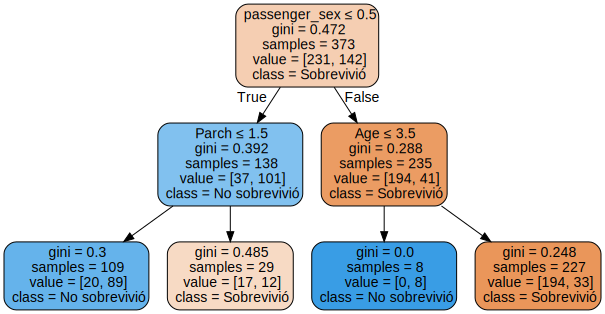

In [23]:
#PRUEBA 

y_tree = arbol.predict(X_validate[:1])

import graphviz 
dot_data = tree.export_graphviz(arbol, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("titanic") 
dot_data = tree.export_graphviz(arbol, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=["Sobrevivió","No sobrevivió"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [130]:
#import sys
#!conda install --yes --prefix  {sys.prefix} python-graphviz